###  MicroGrad demo

In [22]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [23]:
from cugrad.tensor import Tensor
from cugrad.nn import Neuron, Layer, MLP

In [24]:
np.random.seed(1337)
random.seed(1337)

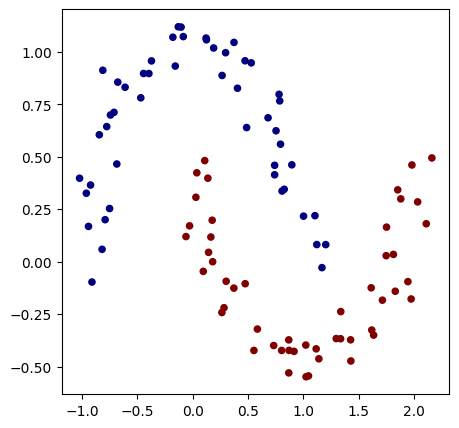

In [25]:
# make up a dataset

from sklearn.datasets import make_moons, make_blobs
X, y = make_moons(n_samples=100, noise=0.1)

y = y*2 - 1 # make y be -1 or 1
# visualize in 2D
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

In [26]:
# initialize a model 
model = MLP(2, [16, 16, 1]) # 2-layer neural network
print(model)
print("number of parameters", len(model.parameters()))
print(model.parameters())

number of parameters 337
[<cugrad.tensor.Tensor object at 0x705dd912fbf0>, <cugrad.tensor.Tensor object at 0x705dd87756f0>, <cugrad.tensor.Tensor object at 0x705dd9b870b0>, <cugrad.tensor.Tensor object at 0x705dd8715fb0>, <cugrad.tensor.Tensor object at 0x705dd8716ff0>, <cugrad.tensor.Tensor object at 0x705dd8715370>, <cugrad.tensor.Tensor object at 0x705dd8769bf0>, <cugrad.tensor.Tensor object at 0x705dd8700370>, <cugrad.tensor.Tensor object at 0x705dd878eaf0>, <cugrad.tensor.Tensor object at 0x705dd878fc70>, <cugrad.tensor.Tensor object at 0x705dd878fc30>, <cugrad.tensor.Tensor object at 0x705dd878fbf0>, <cugrad.tensor.Tensor object at 0x705dd878fbb0>, <cugrad.tensor.Tensor object at 0x705dd878fb70>, <cugrad.tensor.Tensor object at 0x705dd878faf0>, <cugrad.tensor.Tensor object at 0x705dd878fab0>, <cugrad.tensor.Tensor object at 0x705dd878fa70>, <cugrad.tensor.Tensor object at 0x705dd878fa30>, <cugrad.tensor.Tensor object at 0x705dd878f9f0>, <cugrad.tensor.Tensor object at 0x705dd878f

In [27]:
# loss function
def loss(batch_size=None):
    
    # inline DataLoader :)
    if batch_size is None:
        Xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]
    inputs = [list(map(Tensor, xrow)) for xrow in Xb]
    # forward the model to get scores
    scores = list(map(model, inputs))
    # svm "max-margin" loss
    losses = [(Tensor(1.0) + Tensor(-1.0) * Tensor(yi)*scorei[0]).relu() for yi, scorei in zip(yb, scores)]
    def tensor_sum(tensors):
        x = tensors[0]
        for i in range(1, len(tensors)):
            x = x + tensors[i]
        return x
    sm = tensor_sum(losses)
    data_loss = sm * Tensor((1.0 / len(losses)))
    # L2 regularization
    alpha = 1e-4
    reg_loss = Tensor(alpha) * tensor_sum(list((p*p for p in model.parameters())))
    total_loss = data_loss + reg_loss

    
    # also get accuracy
    accuracy = [(yi > 0) == (scorei[0].data > 0) for yi, scorei in zip(yb, scores)]
    return total_loss, sum(accuracy) / len(accuracy)

total_loss, acc = loss()

-1.073015809059143
-0.20016109943389893
-0.8041591644287109
0.28455594182014465
-0.6925235986709595
-0.650646984577179
-0.9754146337509155
-1.1208527088165283
-0.658381998538971
-1.0069090127944946
-0.3446781039237976
0.06428012996912003
0.5330533981323242
-0.7600077986717224
-1.4718143939971924
-1.2492426633834839
-0.9120733737945557
-0.9238817691802979
-0.10729094594717026
0.2420012652873993
-1.4495060443878174
-1.1213501691818237
-1.1043810844421387
-0.5134634971618652
-0.40676450729370117
-0.011105373501777649
-0.795691192150116
-0.8876249194145203
-1.099219560623169
-1.0073277950286865
0.3945041298866272
-1.5065412521362305
0.5017436146736145
-1.0967841148376465
-0.4575638175010681
-0.34495440125465393
-0.9838445782661438
-1.1107919216156006
-1.10870361328125
0.04326125234365463
-1.0567059516906738
0.18999868631362915
-1.1071596145629883
-1.4160032272338867
-0.7455685138702393
-1.1158764362335205
-0.9101555347442627
0.45062536001205444
-0.8597770929336548
-1.0843861103057861
0.000

In [28]:
# optimization
for k in range(10):
    
    # forward
    total_loss, acc = loss()
    
    # backward
    model.zero_grad()
    total_loss.backward()
    
    # update (sgd)
    learning_rate = 1.0 - 0.9*k/100
    for p in model.parameters():
        p.data -= learning_rate * p.grad
    
    if k % 1 == 0:
        print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")


-1.073015809059143
-0.20016109943389893
-0.8041591644287109
0.28455594182014465
-0.6925235986709595
-0.650646984577179
-0.9754146337509155
-1.1208527088165283
-0.658381998538971
-1.0069090127944946
-0.3446781039237976
0.06428012996912003
0.5330533981323242
-0.7600077986717224
-1.4718143939971924
-1.2492426633834839
-0.9120733737945557
-0.9238817691802979
-0.10729094594717026
0.2420012652873993
-1.4495060443878174
-1.1213501691818237
-1.1043810844421387
-0.5134634971618652
-0.40676450729370117
-0.011105373501777649
-0.795691192150116
-0.8876249194145203
-1.099219560623169
-1.0073277950286865
0.3945041298866272
-1.5065412521362305
0.5017436146736145
-1.0967841148376465
-0.4575638175010681
-0.34495440125465393
-0.9838445782661438
-1.1107919216156006
-1.10870361328125
0.04326125234365463
-1.0567059516906738
0.18999868631362915
-1.1071596145629883
-1.4160032272338867
-0.7455685138702393
-1.1158764362335205
-0.9101555347442627
0.45062536001205444
-0.8597770929336548
-1.0843861103057861
0.000

(-1.548639298268643, 1.951360701731357)

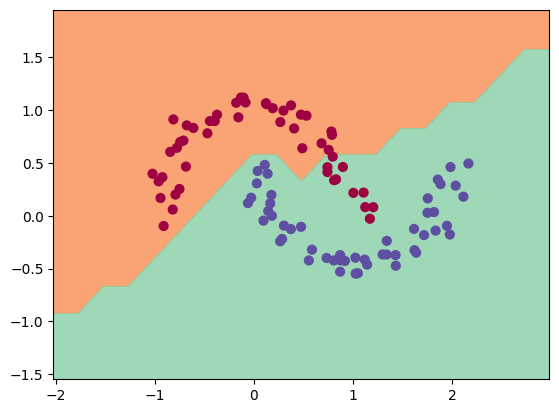

In [29]:
# visualize decision boundary

h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Tensor, xrow)) for xrow in Xmesh]
scores = list(map(model, inputs))
Z = np.array([s[0].data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
